## Plot bandwidth CDF

In [14]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob
import sys
import itertools

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from conf_dict_util import conf_to_dict, dict_to_conf
from qoe_utils import make_bandwidth_series, get_QoE_rr, get_QoE_delay, get_QoE_losses

In [2]:
# from matplotlib import rcParams
# #IEEE Times New Roman (Nimbus Roman)
# rcParams['text.latex.preamble'] = r"\usepackage{mathptmx}"

# #Latex in general
# rcParams['font.family'] = "serif"
# rcParams['font.serif'] = ['Computer Modern']
# rcParams['text.usetex'] = True

In [42]:
# parent_folder = "../new_data/logs_all_4G_Ghent_json"
parent_folder = "../new_data/Norway_3G_data_json"
traces = [os.path.join(parent_folder, log_file) for log_file in os.listdir(parent_folder)]
step_time = 200
traces

['../new_data/Norway_3G_data_json/tram_2010-12-09_1334CET.json',
 '../new_data/Norway_3G_data_json/car_2011-02-10_1611CET.json',
 '../new_data/Norway_3G_data_json/metro_2010-09-14_2303CEST.json',
 '../new_data/Norway_3G_data_json/tram_2011-01-31_1045CET.json',
 '../new_data/Norway_3G_data_json/tram_2010-12-16_1125CET.json',
 '../new_data/Norway_3G_data_json/tram_2011-01-06_0814CET.json',
 '../new_data/Norway_3G_data_json/ferry_2010-09-21_1622CEST.json',
 '../new_data/Norway_3G_data_json/bus_2010-09-28_1407CEST.json',
 '../new_data/Norway_3G_data_json/bus_2011-01-31_1025CET.json',
 '../new_data/Norway_3G_data_json/bus_2011-01-29_1423CET.json',
 '../new_data/Norway_3G_data_json/ferry_2010-09-22_0702CEST.json',
 '../new_data/Norway_3G_data_json/ferry_2010-09-23_1001CEST.json',
 '../new_data/Norway_3G_data_json/tram_2010-12-09_1222CET.json',
 '../new_data/Norway_3G_data_json/train_2011-02-11_1530CET.json',
 '../new_data/Norway_3G_data_json/metro_2010-09-14_1415CEST.json',
 '../new_data/Nor

In [43]:
lolo_capacities = []
std_cap = []
durations = []
for trace_path in traces:

    trace = os.path.basename(trace_path).split(".")[0]

    capacities = make_bandwidth_series(trace_path, step_time)
    duration = (capacities.index[-1] - capacities.index[0]).total_seconds()
    print(trace, duration, "s")
    print(capacities)
    std_cap.append(capacities.std())
    lolo_capacities.append(list(capacities))
    durations.append(duration)

tram_2010-12-09_1334CET 1282.2 s
1970-01-01 00:00:00.000    115.215909
1970-01-01 00:00:00.200    115.215909
1970-01-01 00:00:00.400    115.215909
1970-01-01 00:00:00.600    115.215909
1970-01-01 00:00:00.800    115.215909
                              ...    
1970-01-01 00:21:21.400     35.285714
1970-01-01 00:21:21.600     35.285714
1970-01-01 00:21:21.800     27.525151
1970-01-01 00:21:22.000     27.525151
1970-01-01 00:21:22.200     27.525151
Freq: 200L, Length: 6412, dtype: float64
car_2011-02-10_1611CET 7399.6 s
1970-01-01 00:00:00.000    372.087912
1970-01-01 00:00:00.200    372.087912
1970-01-01 00:00:00.400    372.087912
1970-01-01 00:00:00.600    372.087912
1970-01-01 00:00:00.800    372.087912
                              ...    
1970-01-01 02:03:18.800      0.911392
1970-01-01 02:03:19.000      0.911392
1970-01-01 02:03:19.200      0.911392
1970-01-01 02:03:19.400      0.911392
1970-01-01 02:03:19.600      0.911392
Freq: 200L, Length: 36999, dtype: float64
metro_2010-09-14

tram_2011-01-05_0819CET 1330.8 s
1970-01-01 00:00:00.000    205.794059
1970-01-01 00:00:00.200    205.794059
1970-01-01 00:00:00.400    205.794059
1970-01-01 00:00:00.600    205.794059
1970-01-01 00:00:00.800    205.794059
                              ...    
1970-01-01 00:22:10.000    148.600000
1970-01-01 00:22:10.200    148.600000
1970-01-01 00:22:10.400    148.600000
1970-01-01 00:22:10.600    148.600000
1970-01-01 00:22:10.800    148.600000
Freq: 200L, Length: 6655, dtype: float64
ferry_2010-09-21_1735CEST 1077.2 s
1970-01-01 00:00:00.000    190.789318
1970-01-01 00:00:00.200    190.789318
1970-01-01 00:00:00.400    190.789318
1970-01-01 00:00:00.600    190.789318
1970-01-01 00:00:00.800    190.789318
                              ...    
1970-01-01 00:17:56.400    451.556444
1970-01-01 00:17:56.600    451.556444
1970-01-01 00:17:56.800    451.556444
1970-01-01 00:17:57.000    451.556444
1970-01-01 00:17:57.200    451.556444
Freq: 200L, Length: 5387, dtype: float64
bus_2010-11-10

tram_2010-12-22_0800CET 1408.0 s
1970-01-01 00:00:00.000      0.997343
1970-01-01 00:00:00.200      0.997343
1970-01-01 00:00:00.400      0.997343
1970-01-01 00:00:00.600      0.997343
1970-01-01 00:00:00.800      0.997343
                              ...    
1970-01-01 00:23:27.200    120.163336
1970-01-01 00:23:27.400    120.163336
1970-01-01 00:23:27.600    120.163336
1970-01-01 00:23:27.800    164.978947
1970-01-01 00:23:28.000    164.978947
Freq: 200L, Length: 7041, dtype: float64
metro_2010-10-22_1458CEST 1042.0 s
1970-01-01 00:00:00.000    131.956332
1970-01-01 00:00:00.200    131.956332
1970-01-01 00:00:00.400    131.956332
1970-01-01 00:00:00.600    131.956332
1970-01-01 00:00:00.800    116.756917
                              ...    
1970-01-01 00:17:21.200      9.243243
1970-01-01 00:17:21.400      9.243243
1970-01-01 00:17:21.600     15.933444
1970-01-01 00:17:21.800     15.933444
1970-01-01 00:17:22.000     15.933444
Freq: 200L, Length: 5211, dtype: float64
train_2011-02-

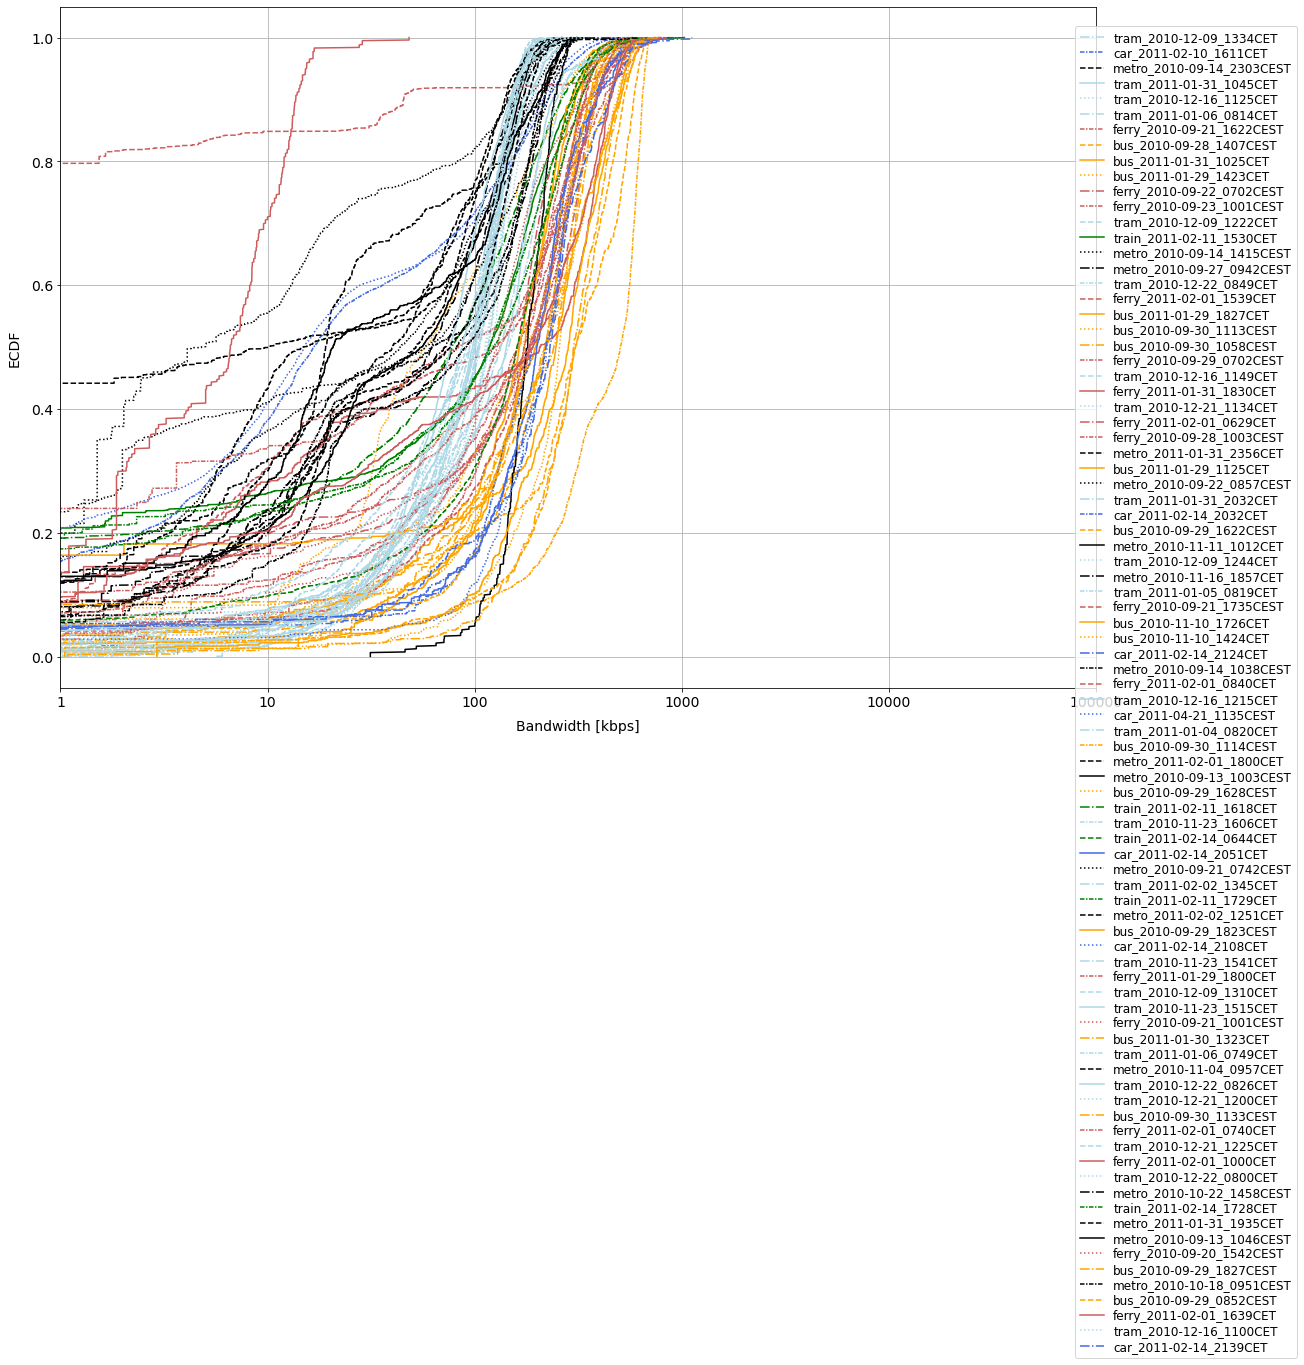

In [46]:


list_cdf_data = lolo_capacities

figsize = (15, 10)
# labelspacing = 0.2
# legend_fontsize = 12
# fontsize = 14
x_label = "Bandwidth [kbps]"

# colors_dataset = ["#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
# linestyles = ["dashed", "solid", "dotted", "dashdot", (0, (3, 1, 1, 1))]
# colors_dataset = ["indianred", "teal", "lightgreen"]
# cd = itertools.cycle(colors_dataset)

fig, ax = plt.subplots(figsize=figsize)
ax.tick_params(axis='both', which='minor',
               length=0,
               # direction='in'
              )
ax.tick_params(axis='both', which='major',
               #length=0,
               # direction='in'
              )
c = 0
for i in range(len(list_cdf_data)):

#     if c%3 == 0:
#         ls = itertools.cycle(linestyles)
    c+=1
    data = list_cdf_data[i]
#     label = trace_dict[traces[i]]
    label = os.path.basename(traces[i]).split(".")[0]
    cdfx = np.sort(data)
    cdfy = np.linspace(1 / len(data), 1.0, len(data))
    if "car" in label:
        color = "royalblue"
    elif "bus" in label:
        color = "orange"
    elif "foot" in label:
        color = "indianred"
    elif "train" in label:
        color = "green"
    elif "tram" in label:
        color = "lightblue"
    elif "metro" in label:
        color = "black"
    elif "ferry" in label:
        color = "indianred"
        
    p = plt.plot(cdfx, cdfy,
                 linestyle=next(ls),
                 label=label,
                 color = color
                )
    plt.tight_layout()

# plt.xticks(np.arange(0,26,2))
plt.xscale('log')
plt.yticks(np.arange(0,1.1,0.2))
ax.tick_params(axis='y', labelsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)

plt.xlabel(x_label, fontsize=fontsize, labelpad=10)
plt.xlim(1,100000)
plt.ylabel('ECDF', fontsize=fontsize, labelpad=10)
plt.grid()

plt.xticks([1, 10, 100, 1000, 10000, 100000], [1, 10, 100, 1000, 10000, 100000])

plt.legend(prop={'size': legend_fontsize}, labelspacing=labelspacing,
           bbox_to_anchor=(1.2,0.98)
          )


# plt.savefig("plots/bandwidth_all_traces.pdf",  bbox_inches='tight')
# plt.savefig("plots/bandwidth_all_traces.png",  bbox_inches='tight', dpi=500, transparent=True)